# Micrograd (part 2)

here we will practice more about magic methods in python to build the autograd/minigrad __Value__ class.


In [3]:
# import packages (always)
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph

%matplotlib inline

class Value:
    def __init__(self, data, _children = (), _op = '', label = '') -> None:
        self.data = data
        self._prev = set(_children)   # the prev nodes in computation graph
        self._op = _op   # store the operation type
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None 
    
    # better print 
    def __repr__(self) -> str:
        return f'Value(data={self.data})'

    #  self + other
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward        
        return out 
    
    # turn other + self into self + other
    def __radd__(self, other):
        return self + other
    
    # self * other
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out    
    
    # turn other * self into self * other
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**(-1)
    
    # x**k
    def __pow__(self, index):
        assert isinstance(index, (int, float)), 'only support int or float for index value'
        x = self.data
        out = Value(x**index, (self,), f'**{index}')
        
        def _backwards():
            self.grad += out.grad * (index * x**(index-1)) 
        out._backward = _backwards
        return out

    def __neg__(self):
        return self*(-1)

    def __sub__(self, other):
        return self + (-other)
    
    
    # tanh(self)
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - out.data ** 2) * out.grad
        out._backward = _backward  
        return out 
    
    # exp(self)
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
        return out
    
    # backpropagation (self should be the final node)
    def backward(self):
        topo = []
        visited = set()
        def build_topo(o):    
            if o not in visited:
                visited.add(o)
                for child in o._prev:
                    build_topo(child)
                topo.append(o)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            



# computation graph functions
def trace(root):
    # build a set of nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr = {'rankdir': 'LR'})  # left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s |data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid+n._op, label = n._op)
            dot.edge(uid+n._op, uid)
        
    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

## continue from part 1

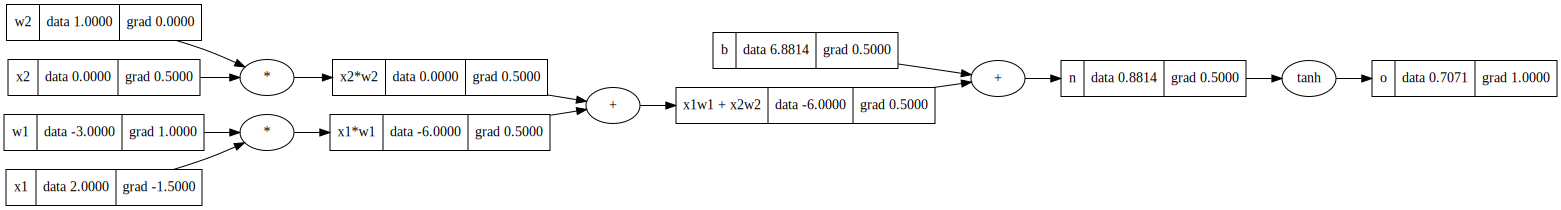

In [2]:
# input 
x1, x2 = Value(2.0, label = 'x1'), Value(0.0, label = 'x2') 
# weights
w1, w2 = Value(-3.0, label = 'w1'), Value(1.0, label = 'w2')
# bias
b = Value(6.88137, label = 'b')
# forward path
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1_add_x2w2 = x1w1 + x2w2; x1w1_add_x2w2.label = 'x1w1 + x2w2'
n = x1w1_add_x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
# back propagation !
o.backward()
draw_dot(o)

if we want to use a Value object to add a constant, it will be a problem

~~~
class Value:
     ......
     def __add__(self, other):
             out = Value(self.data + other.data, (self, other), '+')
             def _backward():
                 self.grad += 1.0 * out.grad
                 other.grad += 1.0 * out.grad
             out._backward = _backward        
             return out 
     ......

a = Value(2.0)
a+1

----------------------
AttributeError                            
     21 def __add__(self, other):
---> 22     out = Value(self.data + other.data, (self, other), '+')
     24     def _backward():
     25         self.grad += 1.0 * out.grad

AttributeError: 'int' object has no attribute 'data'
~~~

To solve this, add 
~~~
other = other if isinstance(other, Value) else Value(other)
~~~



In [11]:
# after fix the bug for both __mul__ and __add__
a = Value(2.0)
a + 1 , a * 2

(Value(data=3.0), Value(data=4.0))

but if we do
~~~
a = Value(2.0)
1 + a  

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
Cell In[12], line 2
      1 a = Value(2.0)
----> 2 1 + a

TypeError: unsupported operand type(s) for +: 'int' and 'Value'
~~~
Why? becasue 1.\_\_add\_\_(a) is not possible

To solve this, we need to use 
~~~
class Value:
      ......
      def __rmul__(self, other):
            return self * other

      def __radd__(self, other):
            return self + other
~~~

if python try 1+a, and fail, it will try \_\_radd\_\_ or \_\_rmul\_\_, and these methods can make 1+a become a+1 

In [30]:
a = Value(2.0)
1 * a

Value(data=2.0)

now add more operation in Value class
1. exp()
2. x**k 
3. __-__
4. __/__

In [29]:
a = Value(2.0)
a.exp()

Value(data=7.38905609893065)

In [36]:
a = Value(2.0)
b = Value(4.0)
a/b

Value(data=0.5)

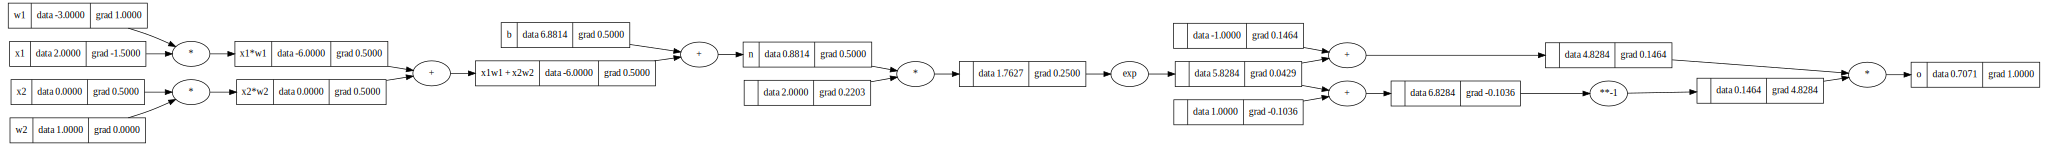

In [37]:
# input 
x1, x2 = Value(2.0, label = 'x1'), Value(0.0, label = 'x2') 
# weights
w1, w2 = Value(-3.0, label = 'w1'), Value(1.0, label = 'w2')
# bias
b = Value(6.88137, label = 'b')
# forward path
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1_add_x2w2 = x1w1 + x2w2; x1w1_add_x2w2.label = 'x1w1 + x2w2'
n = x1w1_add_x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e-1)/(e+1)
# ----
o.label = 'o'
# back propagation !
o.backward()
draw_dot(o)

## now we can build our own neural networks


First, define a single neuron

In [30]:
import random
class Neuron:
    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # w*x + b
        act = sum((wi*xi for (wi,xi) in zip(self.w, x)), self.b)
        return act.tanh()
    
x = [2.0,3.0]
n = Neuron(2)
n(x)

Value(data=0.9968453472900373)

second, define a layer of neurons

In [28]:
class Layer:
    def __init__(self, nin, nout) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

x = [2.0,3.0]    
n = Layer(2,3)
n(x)

[Value(data=-0.8644573151464664),
 Value(data=-0.9625870125018776),
 Value(data=-0.057679423322157114)]

In [32]:
class MLP:
    def __init__(self, nin, nouts) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
x = [2,3,-1]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.32808700438667787)

In [ ]:
# quick crazy for a simgle NN computational graph
draw_dot(n(x))

Create a simple dataset

In [38]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

ypred  = [n(x) for x in xs]
ypred

[Value(data=-0.32808700438667787),
 Value(data=-0.7850803499661706),
 Value(data=-0.777957082922431),
 Value(data=-0.7842948087867448)]

In [41]:
# use MSE
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss


Value(data=5.043016568879086)

In [42]:
loss.backward()

In [44]:
n.layers[0].neurons[0].w[0].grad

3.9510819438810048

In [46]:
# draw_dot(loss)

## now we can train the NN

In [1]:
import random
class Neuron:
    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # w*x + b
        act = sum((wi*xi for (wi,xi) in zip(self.w, x)), self.b)
        return act.tanh()
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [9]:
x = [2,3,-1]
n = MLP(3, [4,4,1])
len(n.parameters())

41

In [10]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

ypred  = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.304410113538119)

A super simple NN
1. lr
2. forward pass
3. loss function 
4. optimizer

In [93]:

lr = 0.01

for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update params
    for p in n.parameters():
        p.data += -lr*p.grad
    
    print(k, loss.data)

0 0.002082212198106819
1 0.0020806155350679397
2 0.0020790212823988624
3 0.002077429434675769
4 0.0020758399864910628
5 0.002074252932453294
6 0.002072668267187108
7 0.0020710859853332033
8 0.00206950608154823
9 0.0020679285505047517
10 0.0020663533868912364
11 0.0020647805854118466
12 0.002063210140786613
13 0.0020616420477511375
14 0.0020600763010567152
15 0.00205851289547015
16 0.0020569518257738074
17 0.0020553930867654524
18 0.0020538366732582728
19 0.002052282580080793


In [94]:
ypred

[Value(data=0.9816583518850963),
 Value(data=-0.9857141986839116),
 Value(data=-0.9714268663252786),
 Value(data=0.9736303500729798)]